In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [0]:
!kaggle datasets download -d vikramtiwari/pix2pix-dataset

pix2pix-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip 'drive/My Drive/Kaggle/pix2pix-dataset.zip' 'maps/*' 

# Load and view the dataset

In [0]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from numpy import load
from matplotlib import pyplot as plt

In [0]:
#load all images in a directory into memory
def load_images(path,size=(256,512)):
  src_list,tar_list=list(),list()
  #enumerate filenames in directory
  for filen in listdir(path):
    #load and resize the image
    pixels=load_img(path+filen,target_size=size)
    #convert to numpy array
    pixels=img_to_array(pixels)
    #split into satellite and map
    sat_img,map_img=pixels[:,:256],pixels[:,256:]
    src_list.append(sat_img)
    tar_list.append(map_img)
  return [asarray(src_list),asarray(tar_list)]

In [0]:
#dataset path and load dataset 
path='maps/maps/train/'
[src_images, tar_images] = load_images(path)


In [10]:
#shape of the two arrays 
print(src_images.shape,tar_images.shape)
#save as compressed numpy array
filename='maps_256.npz'
savez_compressed(filename,src_images,tar_images)

(1096, 256, 256, 3) (1096, 256, 256, 3)


<function matplotlib.pyplot.show>

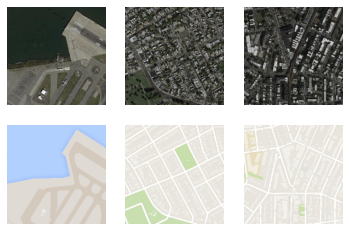

In [11]:
#load the prepared dataset
data=load('maps_256.npz')
src_images,tar_images=data['arr_0'],data['arr_1']
#plot source images
n_samples=3
for i in range(n_samples):
  plt.subplot(2,n_samples,1+i)
  plt.axis('off')
  plt.imshow(src_images[i].astype('uint8'))
#plot target images
for i in range(n_samples):
  plt.subplot(2,n_samples,1+n_samples+i)
  plt.axis('off')
  plt.imshow(tar_images[i].astype('uint8'))
plt.show  

# Develop and Train a Pix2Pix Model

In [0]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import load_model
from numpy.random import randint
 

In [0]:
#define the discriminator model
def define_discriminator(image_shape):
  #weight initialization
  init=RandomNormal(stddev=0.02)
  #source image input
  in_src_image=Input(shape=image_shape)
  #target image input
  in_target_image=Input(shape=image_shape)
  #concatenate images channel-wise
  merged=Concatenate()([in_src_image,in_target_image])
  #C64
  d=Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(merged)
  d=LeakyReLU(alpha=0.2)(d)
  #C128
  d=Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
  d=BatchNormalization()(d)
  d=LeakyReLU(alpha=0.2)(d)
  #C256
  d=Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
  d=BatchNormalization()(d)
  d=LeakyReLU(alpha=0.2)(d)
  #C512
  d=Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
  d=BatchNormalization()(d)
  d=LeakyReLU(alpha=0.2)(d)
  #second last output layer
  d=Conv2D(512,(4,4),padding='same',kernel_initializer=init)(d)
  d=BatchNormalization()(d)
  d=LeakyReLU(alpha=0.2)(d)
  #patch output
  d=Conv2D(1,(4,4),padding='same',kernel_initializer=init)(d)
  patch_out=Activation('sigmoid')(d)
  #define model
  model=Model([in_src_image,in_target_image],patch_out)
  #compile model
  opt=Adam(lr=0.002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt,loss_weights=[0.5])
  return model

In [0]:
#define an encoder block
def define_encoder_block(layer_in,n_filters,batchnorm=True):
  #weight initialization
  init=RandomNormal(stddev=0.02)
  #add downsampling layer
  g=Conv2D(n_filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(layer_in)
  #conditionally add batch normalization
  if batchnorm:
    g=BatchNormalization()(g,training=True)
  #leaky RelU activation
  g=LeakyReLU(alpha=0.2)(g)
  return g

#define a decoder block
def decoder_block(layer_in,skip_in,n_filters,dropout=True):
  #weight initialization
  init=RandomNormal(stddev=0.02)
  #add upsampling layer
  g=Conv2DTranspose(n_filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(layer_in)
  #add batch norm
  g=BatchNormalization()(g,training=True)
  #conditionally add dropout
  if dropout:
    g=Dropout(0.5)(g,training=True)
  #merge with skip connection
  g=Concatenate()([g,skip_in])
  #relu activation
  g=Activation('relu')(g)
  return g 
                    


In [0]:
#define the standalone generator model
def define_generator(image_shape=(256,256,3)):
  #weight initialization
  init=RandomNormal(stddev=0.02)
  #image input
  in_image=Input(shape=image_shape)
  #encoder model
  e1=define_encoder_block(in_image,64,batchnorm=False)
  e2=define_encoder_block(e1,128)
  e3=define_encoder_block(e2,256)
  e4=define_encoder_block(e3,512)
  e5=define_encoder_block(e4,512)
  e6=define_encoder_block(e5,512)
  e7=define_encoder_block(e6,512)
  #bottleneck no batch norm and relu
  b=Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(e7)
  b=Activation('relu')(b)
  #decoder model
  d1=decoder_block(b,e7,512)
  d2=decoder_block(d1,e6,512)
  d3=decoder_block(d2,e5,512)
  d4=decoder_block(d3,e4,512,dropout=False)
  d5=decoder_block(d4,e3,256,dropout=False)
  d6=decoder_block(d5,e2,128,dropout=False)
  d7=decoder_block(d6,e1,64,dropout=False)
  #output
  g=Conv2DTranspose(3,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d7)
  out_image=Activation('tanh')(g)
  #define model
  model=Model(in_image,out_image)
  return model

In [0]:
#define the combined generator and discriminator model, for updating the generator
def define_gan(g_model,d_model,image_shape):
  #make weights in the discriminator not trainable
  d_model.trainable=False
  #define the source image
  in_src=Input(shape=image_shape)
  #connect the source image to the generator input
  gen_out=g_model(in_src)
  #connect the source input and generator output to the discriminator input
  dis_out=d_model([in_src,gen_out])
  model=Model(in_src,[dis_out,gen_out]) 
  #compile model
  opt=Adam(lr=0.002,beta_1=0.5)
  model.compile(loss=['binary_crossentropy','mae'],optimizer=opt,loss_weights=[1,100])
  return model

# Load and prepare data

In [0]:
#load and prepare training images
def load_real_samples(filename):
  #load compressed arrays
  data=load(filename)
  #unpack arrays
  X1,X2=data['arr_0'],data['arr_1']
  #scale from [0,255] to [-1,1]
  X1=(X1-127.5)/127.5
  X2=(X2-127.5)/127.5
  return [X1,X2]

In [0]:
#select a batch of random samples,returns images and target
def generate_real_samples(dataset,n_samples,patch_shape):
  #unpack dataset
  trainA,trainB=dataset
  #choose random instances
  ix=randint(0,trainA.shape[0],n_samples)
  #retrieve selected images
  X1, X2 = trainA[ix], trainB[ix]
  #generate 'real' class labels(1)
  y=ones((n_samples,patch_shape,patch_shape,1))
  return [X1,X2],y
  

In [0]:
#select a batch of images, returns images and targets
def generate_fake_samples(g_model,samples,patch_shape):
  #generate fake instance
  X=g_model.predict(samples)
  #create 'fake' class labels(0)
  y=zeros((len(X),patch_shape,patch_shape,1))
  return X,y

In [0]:
#generate samples and save as a plot and save the model
def summarize_performance(step,g_model,dataset,n_samples=3):
  #select a sample of input images
  [X_realA,X_realB],_=generate_real_samples(dataset,n_samples,1)
  #generate a batch of fake samples
  X_fakeB, _=generate_fake_samples(g_model,X_realA,1)
  #scale all pixels from [-1,1] to [0,1]
  X_realA=(X_realA+1)/2.0
  X_realB=(X_realB+1)/2.0
  X_fakeB=(X_fakeB+1)/2.0
  #plot real source images
  for i in range(n_samples):
    plt.subplot(3,n_samples,1+i)
    plt.axis('off')
    plt.imshow(X_realA[i])
  #plot generated target images
  for i in range(n_samples):
    plt.subplot(3,n_samples,1+n_samples+i)
    plt.axis('off')
    plt.imshow(X_fakeB[i])
  #plot real target images
  for i in range(n_samples):
    plt.subplot(3,n_samples,1+n_samples*2+i)
    plt.axis('off')
    plt.imshow(X_realB[i]) 
  #save plot to file
  filename1='plot_%06d.png' % (step+1)
  plt.savefig(filename1)
  plt.close()
  #save the generator model
  filename2='model_%06d.h5' % (step+1)
  g_model.save(filename2)
  


# Train pix2pix model

In [0]:
def train(d_model,g_model,gan_model,dataset,n_epochs=100,n_batch=1):
  #determine the output square shape of the discriminator
  n_patch=d_model.output_shape[1]
  #unpack dataset
  trainA,trainB=dataset
  #calculate no. of batches per training epoch
  bat_per_epo=int(len(trainA)/n_batch)
  #calculate the no. of training iterations
  n_steps=bat_per_epo * n_epochs
  #manually enumerate epochs
  for i in range(n_steps):
    #select a batch of real samples
    [X_realA,X_realB],y_real=generate_real_samples(dataset,n_batch,n_patch)
    #generate a batch of fake samples
    X_fakeB,y_fake=generate_fake_samples(g_model,X_realA,n_patch)
    #update discriminator for real samples
    d_loss1=d_model.train_on_batch([X_realA,X_realB],y_real)
    #update discriminator for generated samples
    d_loss2=d_model.train_on_batch([X_realA,X_fakeB],y_fake)
    #update the generator
    g_loss,_,_=gan_model.train_on_batch(X_realA,[y_real,X_realB])
    #summarize performance
    if i%500==0:
      print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
    #summarize model performance
    if (i+1)%(bat_per_epo*10)==0:
      summarize_performance(i,g_model,dataset)
    

In [22]:
#load image data
dataset=load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)


Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


In [0]:
#define input shape based on the loaded dataset
image_shape=dataset[0].shape[1:]
#define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)


In [0]:
#define the composite model
gan_model=define_gan(g_model,d_model,image_shape)

In [25]:
#train model
train(d_model,g_model,gan_model,dataset)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, d1[0.490] d2[3.795] g[86.740]
>501, d1[0.011] d2[0.214] g[19.914]
>1001, d1[0.001] d2[0.177] g[15.939]
>1501, d1[0.044] d2[0.126] g[13.218]
>2001, d1[0.120] d2[0.109] g[10.916]
>2501, d1[0.326] d2[0.242] g[7.634]
>3001, d1[0.877] d2[0.172] g[9.577]
>3501, d1[0.003] d2[0.191] g[10.223]
>4001, d1[0.287] d2[0.150] g[7.881]
>4501, d1[0.001] d2[0.130] g[21.867]
>5001, d1[0.359] d2[0.680] g[11.764]
>5501, d1[0.964] d2[0.169] g[8.004]
>6001, d1[0.331] d2[0.329] g[7.305]
>6501, d1[0.156] d2[0.092] g[8.287]
>7001, d1[0.304] d2[0.125] g[10.506]
>7501, d1[0.150] d2[0.320] g[8.901]
>8001, d1[0.002] d2[0.069] g[14.175]
>8501, d1[0.067] d2[0.129] g[9.185]
>9001, d1[0.067] d2[0.213] g[8.374]
>9501, d1[0.643] d2[0.274] g[8.211]
>10001, d1[0.572] d2[0.265] g[7.269]
>10501, d1[0.509] d2[0.136] g[9.725]
>11001, d1[0.051] d2[0.374] g[8.041]
>11501, d1[0.001] d2[0.106] g[11.244]
>12001, d1[0.233] d2[0.090] g[10.359]
>12501, d1[0.066] d2[0.097] g[8.371]
>13001, d1[0.019] d2[0.116] g[7.620]
>13501, d1[0.

# Translate images with pix2pix

In [0]:
def plot_images(src_img,gen_img,tar_img):
  images=vstack((src_img,gen_img,tar_img))
  #scale from [-1 1] to [0 1]
  images=(images+1)/2.0
  titles=['Source','Generated','Expected']
  #plot images row by row
  for i in range(len(images)):
    #define subplot 
    plt.subplot(1,3,1+i)
    #turn off axis
    plt.axis('off')
    #plot raw pixel data
    plt.imshow(images[i])
    #show title 
    plt.title(titles[i])
  plt.show()

In [0]:
#load dataset
[X1,X2]=load_real_samples('maps_256.npz')

In [29]:
# load model
model = load_model('model_109600.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

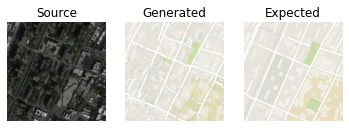

In [37]:
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

# Translate google images to satellite images

In [0]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	# return in reverse order
	return [X2, X1]

This means that the model will take Google map images as input and learn to generate satellite images.

Run the model as before.

# Extensions


**Standalone Satellite.** Develop an example of translating standalone Google map images to satellite images, as we did for satellite to Google map images.

**New Image.** Locate a satellite image for an entirely new location and translate it to a Google map and consider the result compared to the actual image in Google maps.

**More Training.** Continue training the model for another 100 epochs and evaluate whether the additional training results in further improvements in image quality.

**Image Augmentation.** Use some minor image augmentation during training as described in the Pix2Pix paper and evaluate whether it results in better quality generated images.